In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.special import expit

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
db = pd.read_csv('data/mon.csv')
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
db['subject'] = db['subn'].astype('category')
db = db.dropna()
db['choice'] = db['choice'].astype('int')
db = db.sort_values('subn').reset_index(drop=True)
db.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn,subject
0,82,0,5,0.5,0.74,10,0.0,0,0
1,23,0,8,0.5,0.50,10,0.0,0,0
2,24,0,5,0.5,0.50,10,0.0,0,0
3,25,0,8,0.5,0.00,10,0.0,0,0
4,26,1,25,0.5,0.24,10,0.0,0,0


In [133]:
numsubjs = max(db.subn)+1
values    = np.array(db.value)
risk      = np.array(db.risk)
ambiguity = np.array(db.ambiguity)
choices   = np.array(db.choice)

refValue       = 5
refProbability = 1
refAmbiguity   = 0

refProbabilities = np.tile(refProbability, len(values))
refValues        = np.tile(refValue,       len(values))
refAmbiguities   = np.tile(refAmbiguity,   len(values))

n_trials = np.arange(len(choices))

sub_idx = np.arange(numsubjs)
sub_idx = np.repeat(sub_idx, 84)

In [134]:
sub_idx = db.subn.tolist()


In [158]:
with pm.Model() as RiskAmbOld:
    # hyper
    rMu = pm.Normal('rMu', 0,1)
    rSig = pm.Exponential('rSig', 1)
    aMu = pm.Normal('aMu', 0,1)
    aSig = pm.Exponential('aSig', 1)
    
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    
    α = pm.Lognormal('α', rMu, rSig, shape = numsubjs)
    β = pm.Normal('β', aMu, aSig, shape = numsubjs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = numsubjs)
    # Priors for unknown model parameters
    
      
    # Expected value of outcome
    svLotto = (values ** α[sub_idx]) * (risk-(β[sub_idx] * (ambiguity/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=db.choice)
    choice = pm.Binomial('choice',1, mu, observed=choices)
    trace2 = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, nSig, nMu, aSig, aMu, rSig, rMu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 197 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [135]:
with pm.Model() as RiskAmb:
    # hyper
    a = pm.Poisson('a', 1)
    b = pm.Poisson('b', 1)
    
    aMu = pm.Normal('aMu', 0,1)
    aSig = pm.Exponential('aSig', 1)
    
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    
    α = pm.Beta('α', a, b, shape = numsubjs)
    β = pm.Normal('β', aMu, aSig, shape = numsubjs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = numsubjs)
    # Priors for unknown model parameters
    
    riskTol = α * 2
    

    # Expected value of outcome
    svLotto = (values ** riskTol[sub_idx]) * (risk-(β[sub_idx] * (ambiguity/2)))
    svRef = 5 ** riskTol[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=db.choice)
    choice = pm.Binomial('choice',1, mu, observed=choices)
    trace3 = pm.sample(2000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α, nSig, nMu, aSig, aMu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 177 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

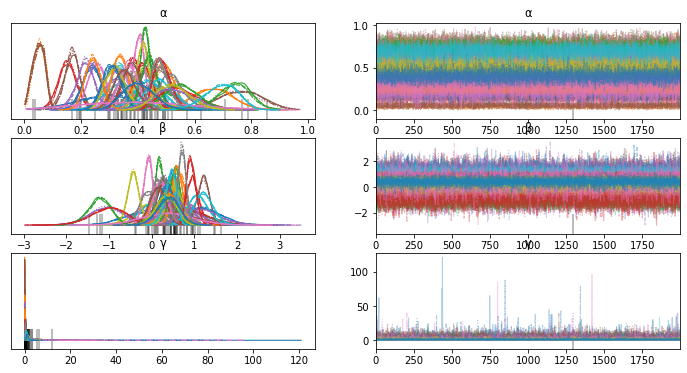

In [136]:
az.plot_trace(trace3, var_names=['α','β','γ'])

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


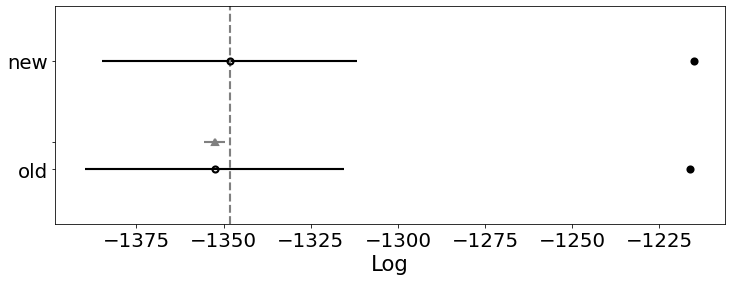

In [164]:
model_compare = az.compare(
    {
        "old": trace2,
        "new": trace3,
    }
)
az.plot_compare(model_compare, figsize=(12, 4))

plt.show()


In [137]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(
        trace3
    )

In [150]:
ppc['choice'].shape

(8000, 4150)

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


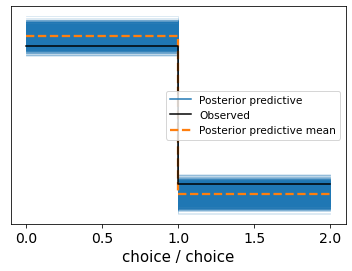

In [138]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [139]:
pc = az.from_pymc3(posterior_predictive=ppc, model=RiskAmb)
pp = np.mean(pc.posterior_predictive.choice.values, axis=1)

In [157]:
np.sum((choices-pp)**2)

388.15250828125

In [159]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [147]:
pp

array([[0.00875 , 0.043875, 0.01125 , ..., 0.31275 , 0.201   , 0.88875 ]])

In [116]:
x = pp[0].T.shape

In [151]:
len(choices)

4150

In [144]:
cf_matrix = confusion_matrix(choices, pp[0].T)
print(cf_matrix)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [5]:
az.summary(trace2, var_names=['α'])[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.879,0.065,0.754,1.002,0.001,0.000,12925.0,11285.0,1.0
α[1],0.157,0.030,0.100,0.218,0.000,0.000,12596.0,9377.0,1.0
α[2],0.891,0.131,0.649,1.138,0.001,0.001,11642.0,11241.0,1.0
α[3],0.327,0.053,0.228,0.428,0.000,0.000,15320.0,10423.0,1.0
α[4],0.651,0.097,0.469,0.833,0.001,0.001,11307.0,9671.0,1.0


In [7]:
az.summary(trace2, var_names=['β'])[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],0.476,0.136,0.220,0.725,0.001,0.001,15524.0,12107.0,1.0
β[1],0.469,0.505,-0.421,1.438,0.004,0.004,17679.0,10891.0,1.0
β[2],0.410,0.298,-0.160,0.964,0.003,0.002,14346.0,11318.0,1.0
β[3],0.873,0.427,0.095,1.658,0.004,0.003,16015.0,10981.0,1.0
β[4],0.657,0.278,0.154,1.198,0.003,0.002,12709.0,10174.0,1.0


In [8]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)

age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
age.columns.values[0] = "sub"
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))

df = df.merge(age, left_on='sub', right_on='sub')
df.head()

,sub,subn,Age,Male
0,10,0,18.742466,1.0
1,11,1,43.301370,0.0
2,13,2,48.684932,0.0
3,14,3,26.558904,0.0
4,15,4,58.394521,0.0


In [9]:
alpha = az.summary(trace3, var_names=['α'])[['mean','sd']]
beta = az.summary(trace3, var_names=['β'])[['mean','sd']]

alpha = alpha.rename(columns={'mean': "alpha", 'sd': 'alpha_sd'}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta", 'sd': 'beta_sd'}).reset_index(drop=True)

df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)

df.head()

,sub,subn,Age,Male,alpha,alpha_sd,beta,beta_sd
0,10,0,18.742466,1.0,0.879,0.065,0.476,0.136
1,11,1,43.301370,0.0,0.157,0.030,0.469,0.505
2,13,2,48.684932,0.0,0.891,0.131,0.410,0.298
3,14,3,26.558904,0.0,0.327,0.053,0.873,0.427
4,15,4,58.394521,0.0,0.651,0.097,0.657,0.278


<AxesSubplot:xlabel='Age', ylabel='alpha'>

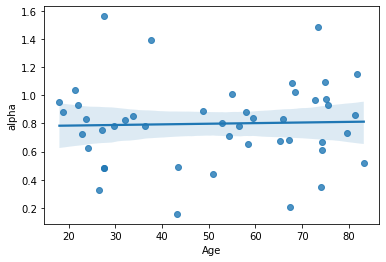

In [10]:
sns.regplot(x='Age', y='alpha', data=df)

<AxesSubplot:xlabel='Age', ylabel='beta'>

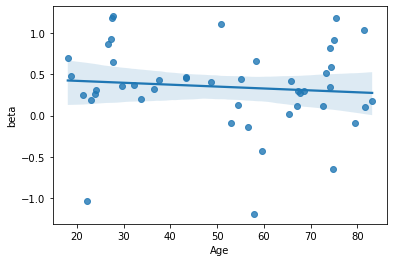

In [11]:
sns.regplot(x='Age', y='beta', data=df)

In [13]:
d10 = db[db['sub']==10]
d10.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn,subject
0,41,0.0,12,0.5,0.74,10,0.0,0,0
1,23,0.0,8,0.5,0.50,10,0.0,0,0
2,24,0.0,5,0.5,0.50,10,0.0,0,0
3,25,0.0,8,0.5,0.00,10,0.0,0,0
4,26,1.0,25,0.5,0.24,10,0.0,0,0


<AxesSubplot:xlabel='value', ylabel='choice'>

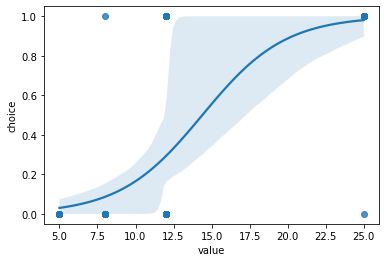

In [14]:
sns.regplot(x='value',y='choice', data=d10, logistic=True)

In [18]:
svRef = 5 ** df.alpha[0]
svLotto = d10.value ** df.alpha[0] * (d10.risk - df.beta[0] * (d10.ambiguity/2))
p = sp.special.expit(svLotto - svRef)

d10['sim'] = np.random.binomial(1, p, len(p))
d10.head()

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn,subject,sim
0,41,0.0,12,0.5,0.74,10,0.0,0,0,0
1,23,0.0,8,0.5,0.50,10,0.0,0,0,0
2,24,0.0,5,0.5,0.50,10,0.0,0,0,0
3,25,0.0,8,0.5,0.00,10,0.0,0,0,1
4,26,1.0,25,0.5,0.24,10,0.0,0,0,1


<AxesSubplot:xlabel='value', ylabel='choice'>

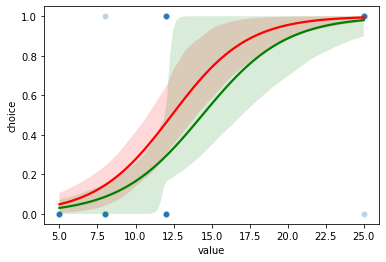

In [27]:
sns.scatterplot(x='value', y='choice', data = d10, alpha=0.3)
sns.regplot(x='value',y='sim', data=d10, logistic=True, scatter=False , color='red')
sns.regplot(x='value',y='choice', data=d10, logistic=True, scatter=False , color='green')

In [68]:
db.groupby('choice').count()

,Unnamed: 0,value,risk,ambiguity,sub,catch,subn,subject
choice,,,,,,,,
0.0,2429,2429,2429,2429,2429,2429,2429,2429
1.0,1721,1721,1721,1721,1721,1721,1721,1721
